In [5]:
import pandas as pd 
import numpy as np
import datetime as dt
import requests
import matplotlib as mlt
import seaborn as sns
from scipy import stats
import warnings
import tweepy
from tweepy import OAuthHandler
import json
import os
warnings.filterwarnings('ignore')
%matplotlib inline

In [6]:
archive_df=pd.read_csv('twitter-archive-enhanced.csv')
archive_df.shape

(2356, 17)

In [ ]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = 'HIDDEN'
consumer_secret = 'HIDDEN'
access_token = 'HIDDEN'
access_secret = 'HIDDEN'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# NOTE TO REVIEWER: this student had mobile verification issues so the following
# Twitter API code was sent to this student from a Udacity instructor
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = archive_df.tweet_id.values
len(tweet_ids)

# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet-json copy.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass

print(fails_dict)


In [8]:
df_json_list=[]
with open('tweet-json copy','r') as tweetjson:
    for line in tweetjson:
        line = json.loads(line.strip())
        id= line["id"]
        retweet_count=line["retweet_count"]
        favorite_count=line["favorite_count"]
        df_json_list.append({'id':id,'retweet_count':retweet_count,'favorite_count':favorite_count })
api_df=pd.DataFrame(df_json_list,columns = ['id','retweet_count','favorite_count'])

In [12]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
image = requests.get(url)
folder_name='image_predictions'
os.mkdir(folder_name)
with open (os.path.join(folder_name,
                        url.split('/')[-1]),mode='wb')as file:
    file.write(image.content)
image_predictions_df = pd.read_csv('image_predictions/image-predictions.tsv',sep='\t')
image_predictions_df.shape

(2075, 12)

In [13]:
api_df.shape

(2354, 3)

In [14]:
dropped_values=archive_df[archive_df['retweeted_status_id'].notnull()|archive_df['in_reply_to_status_id'].notnull()]
archive_df_drop=archive_df.drop(dropped_values.index)
archive_df_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

In [15]:
archive_df_drop.iloc[:, -4: ] = archive_df_drop.iloc[:, -4: ].replace('None','')
api_df.info()
image_predictions_df.info()
archive_df_drop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   id              2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-nu

In [16]:
archive_df_drop=archive_df_drop.drop(columns=['retweeted_status_id','retweeted_status_timestamp','retweeted_status_user_id'],
                                     errors='ignore')
archive_df_drop=archive_df_drop.drop(columns=['in_reply_to_status_id','in_reply_to_user_id'],errors='ignore')

In [17]:
archive_df_drop['dogs_classification'] = archive_df_drop.apply(lambda row: row['doggo'] + 
                                                               row['floofer']+row['pupper']+row['puppo'], axis=1)
archive_df_drop['dogs_classification'].value_counts()
double_class = archive_df_drop[(archive_df_drop['dogs_classification'] =='doggopupper') 
                               | (archive_df_drop['dogs_classification'] =='doggofloofer')
                               |(archive_df_drop['dogs_classification'] =='doggopuppo')]
archive_df_drop=archive_df_drop.drop(double_class.index)
archive_df_drop['rating_numerator'].value_counts(ascending=False)
archive_df_drop['rating_numerator'].describe()
archive_df_drop['rating_numerator'].mean()
archive_df_drop['rating_denominator'].value_counts(ascending=False)
archive_df_drop['rating_denominator'].describe()
archive_df_drop['rating_denominator'].mean()
denomin_drop = archive_df_drop[archive_df_drop['rating_denominator']!=10]
archive_df_drop=archive_df_drop.drop(denomin_drop.index)
archive_df_drop['name'].value_counts()
archive_df_drop['name'].describe()
archive_df_drop.iloc[:, -8: ] = archive_df_drop.iloc[:, -8: ].replace(['None','a'],'null')
archive_df_drop['timestamp'] = pd.to_datetime(archive_df_drop['timestamp'])

In [18]:
image_predictions_df = image_predictions_df[(image_predictions_df['p1_dog'] ==True) & (image_predictions_df['p2_dog'] ==True)
                                            & (image_predictions_df['p3_dog'] ==True)]
image_predictions_df=image_predictions_df.rename(columns={"tweet_id":"tweet_id","jpg_url":"jpg_url","img_num":"img_num",
                                                          "p1":"1st_prediction","p1_conf":"1st_prediction_conf",
                                                          "p1_dog":"1st_prediction_dog","p2":"2nd_prediction",
                                                          "p2_conf":"2nd_prediction_conf","p2_dog":"2nd_prediction_dog",
                                                          "p3":"3rd_prediction","p3_conf":"3rd_prediction_conf",
                                                          "p3_dog":"3rd_prediction_dog"}) 
image_predictions_df["1st_prediction"].value_counts()
image_predictions_df["2nd_prediction"].value_counts()
image_predictions_df["3rd_prediction"].value_counts()
tweets_with_image = list(image_predictions_df.tweet_id.unique())
len(tweets_with_image) == archive_df_drop.tweet_id.isin(tweets_with_image).sum()
archive_df_drop = archive_df_drop[archive_df_drop.tweet_id.isin(tweets_with_image)]
len(tweets_with_image) == archive_df_drop.tweet_id.isin(tweets_with_image).sum()

False

In [19]:
api_df=api_df.rename(columns={"id": "tweet_id", "retweet_count": "retweet_count","favourite_count":"favourite_count"})
tweet_data = pd.merge((archive_df_drop[['tweet_id','timestamp','source','text','expanded_urls']]),
                      api_df, on='tweet_id', how='inner')
dogs_data=pd.merge(archive_df_drop[['tweet_id','timestamp','rating_numerator','rating_denominator','name','dogs_classification']],
                    image_predictions_df,on='tweet_id',how='inner')

In [20]:
dog_class=archive_df_drop[(archive_df_drop['doggo']=='doggo')+(archive_df_drop['pupper']=='pupper')+(archive_df_drop['puppo']=='puppo')+(archive_df_drop['floofer']=='floofer')]
dog_class['dogs_classification'].value_counts()


pupper     119
doggo       39
puppo       18
floofer      6
Name: dogs_classification, dtype: int64

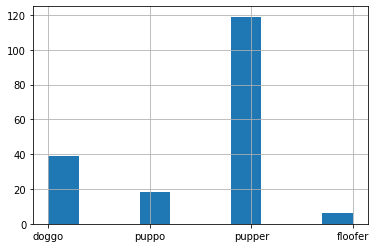

In [21]:
dog_class['dogs_classification'].hist()

In [22]:
tweet_data["retweet_count"].describe()

count     1174.000000
mean      2758.096252
std       4535.201131
min         16.000000
25%        648.500000
50%       1418.000000
75%       3226.250000
max      56625.000000
Name: retweet_count, dtype: float64

In [23]:
tweet_data["favorite_count"].describe()

count      1174.000000
mean       9332.022147
std       12623.379263
min          81.000000
25%        2219.250000
50%        4540.000000
75%       11734.750000
max      132810.000000
Name: favorite_count, dtype: float64

In [24]:
rating_analyze=dogs_data.groupby(['dogs_classification']).describe()[['rating_numerator','rating_denominator']]

In [25]:
rating_analyze.max()

rating_numerator    count    992.000000
                    mean      12.055556
                    std        1.978628
                    min       10.000000
                    25%       12.000000
                    50%       12.500000
                    75%       13.000000
                    max       27.000000
rating_denominator  count    992.000000
                    mean      10.000000
                    std        0.000000
                    min       10.000000
                    25%       10.000000
                    50%       10.000000
                    75%       10.000000
                    max       10.000000
dtype: float64

In [26]:
prediction_confidence=dogs_data.groupby(['dogs_classification']).describe()[['1st_prediction_conf','2nd_prediction_conf','3rd_prediction_conf']]

In [27]:
prediction_confidence.max()

1st_prediction_conf  count    992.000000
                     mean       0.702760
                     std        0.307513
                     min        0.359860
                     25%        0.544080
                     50%        0.755945
                     75%        0.957464
                     max        0.999876
2nd_prediction_conf  count    992.000000
                     mean       0.190693
                     std        0.160702
                     min        0.008758
                     25%        0.114839
                     50%        0.168747
                     75%        0.297003
                     max        0.467678
3rd_prediction_conf  count    992.000000
                     mean       0.071525
                     std        0.058315
                     min        0.002140
                     25%        0.033726
                     50%        0.071732
                     75%        0.097503
                     max        0.271042
dtype: float64

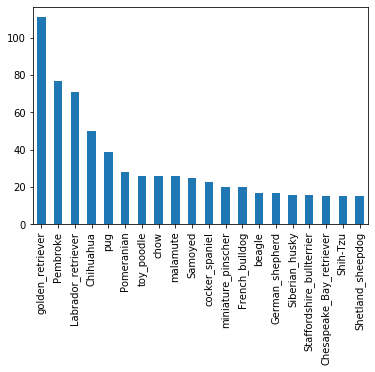

In [28]:
dogs_data['1st_prediction'].value_counts().head(20).plot.bar()

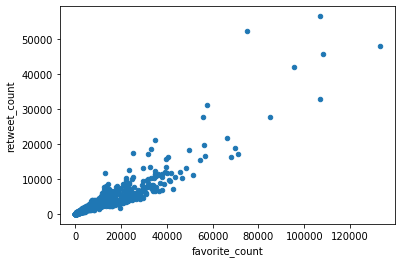

In [29]:
tweet_data.plot(x="favorite_count",y="retweet_count",kind='scatter')

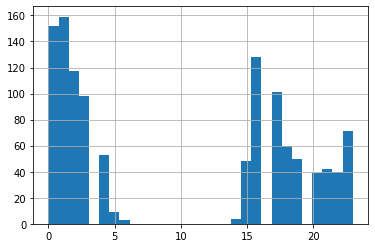

In [30]:
timing=tweet_data['timestamp'].dt.hour
timing.hist(bins=30)

In [31]:
tweet_data.to_csv('tweet_data.csv',index=False)
dogs_data.to_csv('dogs_data.csv',index=False)
merge=pd.merge(tweet_data,dogs_data,on='tweet_id',how='inner')
merge.to_csv('twitter_archive_master.csv',index=False)